In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

K means clustering on wholesale customers data

In [16]:
data=pd.read_csv('Wholesale customers data.csv')
#categorical_features = ['Region']
#data=pd.get_dummies(data,columns=categorical_features) One hot encoding

colnames=['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
print(data.shape)
data.head()

(440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


**Channel**=> *1*: Hotel, Restaurants, Cafe
*2*: Retail   

Demographics
***Region***=> *1*: Lisbon
*2*: Oporto
*3*: Other



In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


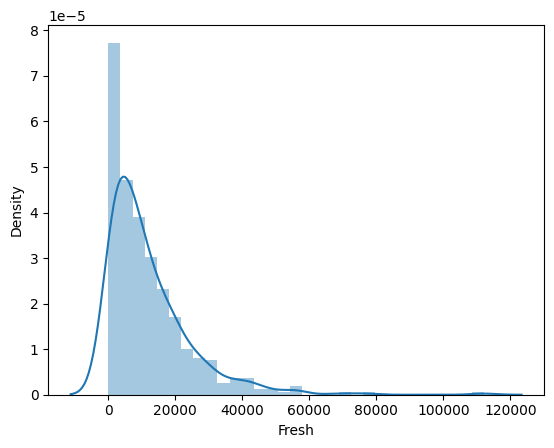

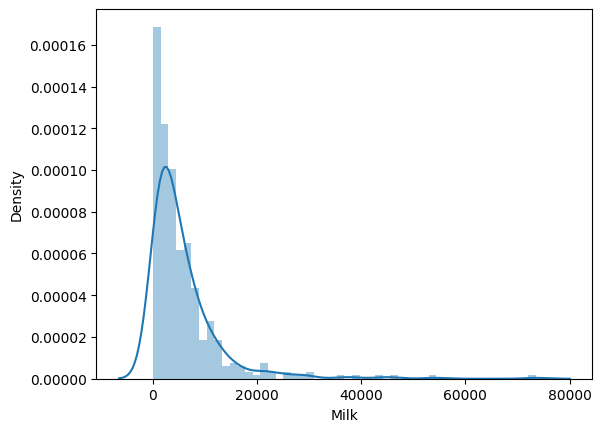

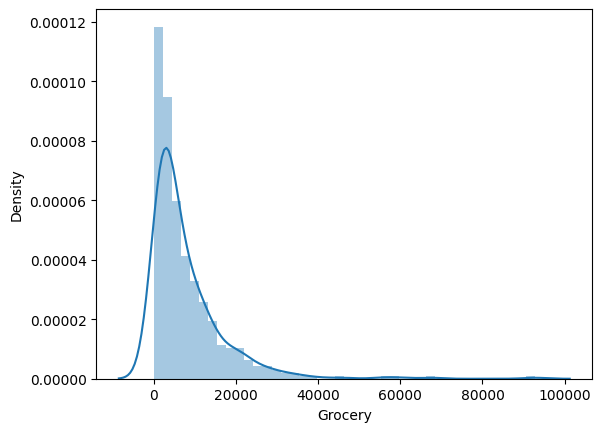

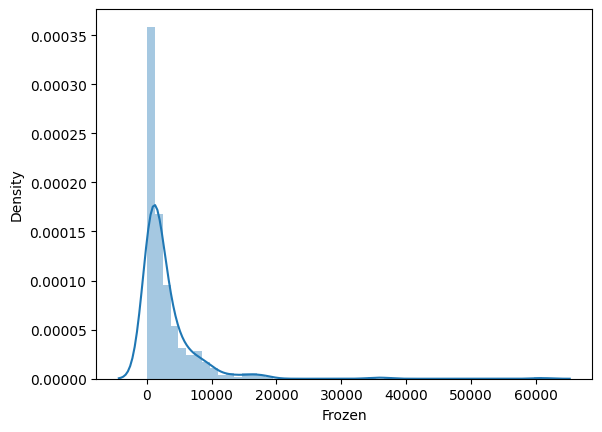

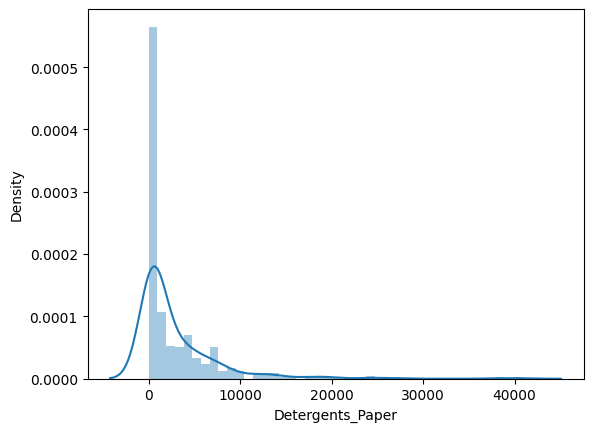

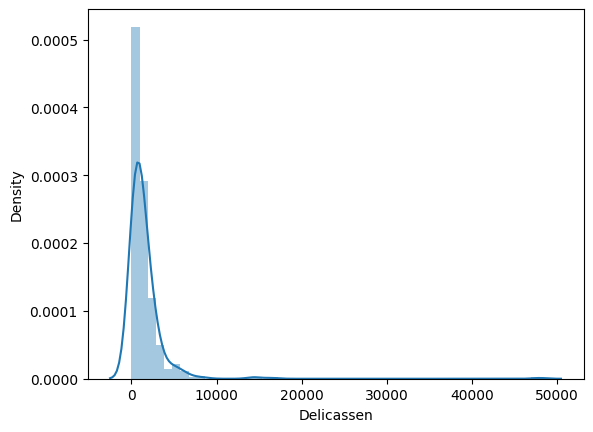

In [18]:
for i in colnames:
  plt.figure()
  sns.distplot(data[i])

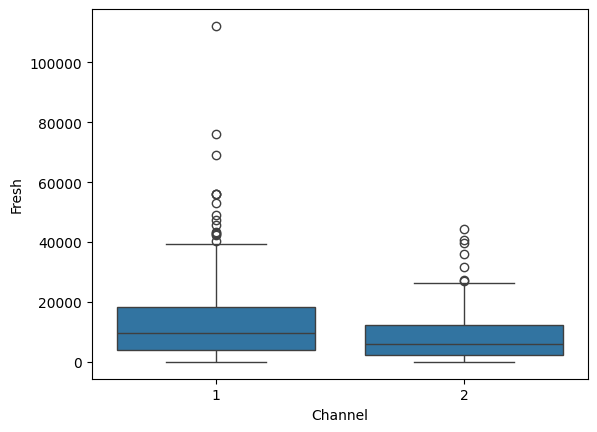

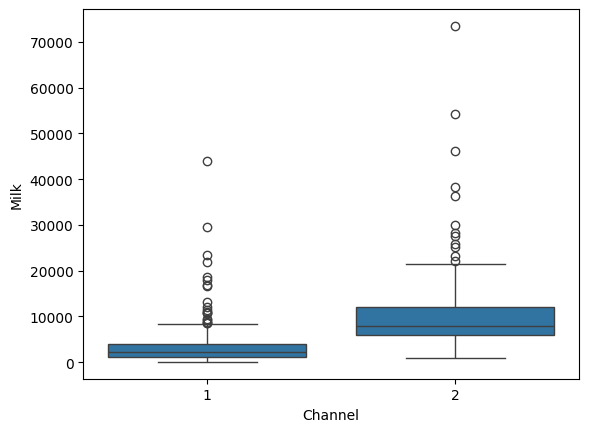

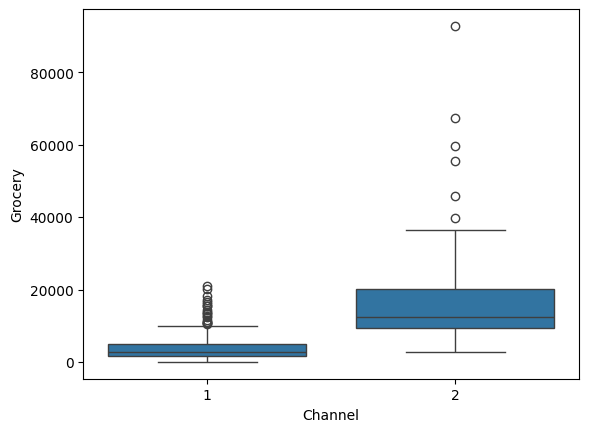

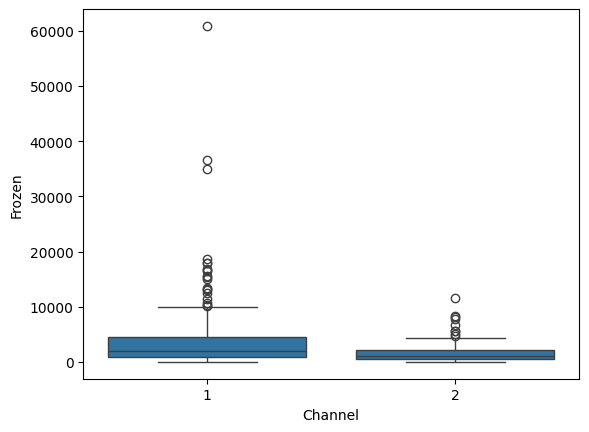

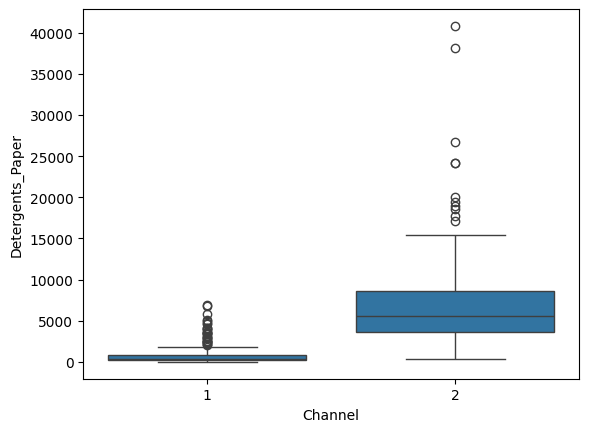

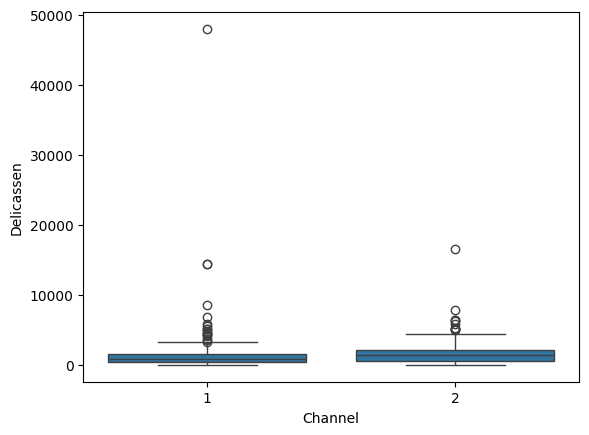

In [19]:
for i in colnames:
    plt.figure()
    sns.boxplot(data=data,x='Channel',y=data[i])

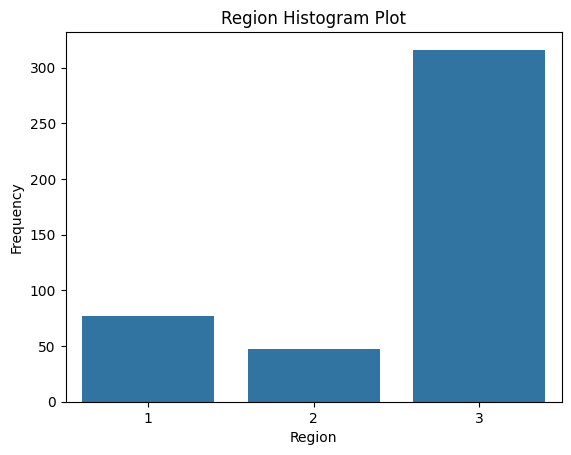

In [34]:
#Visualising 'Region' data
sns.countplot(x ='Region',hue = "smoker", data = data)
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.title('Region Histogram Plot')
plt.show()

Clearly people from 'other' region are much higher in number than Lisbon and Oporto. Less number of people from the specific cities chosen reduces the significance of this column and therefore can be excluded from our data.

---



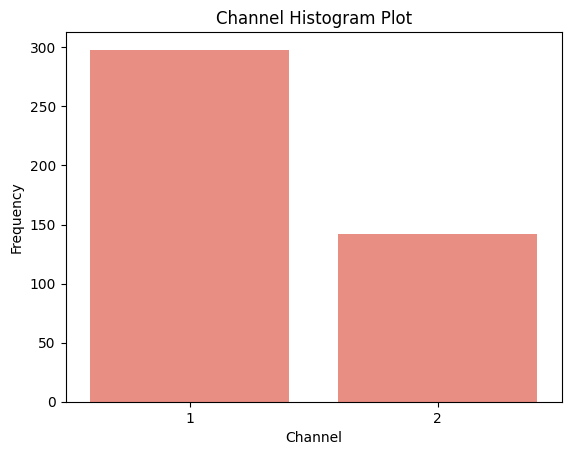

In [36]:
#Visualising 'Channel' data
sns.countplot(x ='Channel', data = data,color="salmon")  # 'auto' for automatic bin selection
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.title('Channel Histogram Plot')
plt.show()

Conclusion: There are good amount of both HoReCa and Retail Channel customers

---




In [22]:
#PCA
#data scaling and centering

numerical_data=data[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']]
numerical_data=numerical_data.T

scaled_data=preprocessing.scale(numerical_data.T) #data.T is the transpose of data.
#we passed transpose of data because scale function expects samples to be rows
pca=PCA()
pca.fit(scaled_data)
#generating coordinates for pca graph
pca_data=pca.transform(scaled_data)

Text(0.5, 1.0, 'Scree Plot')

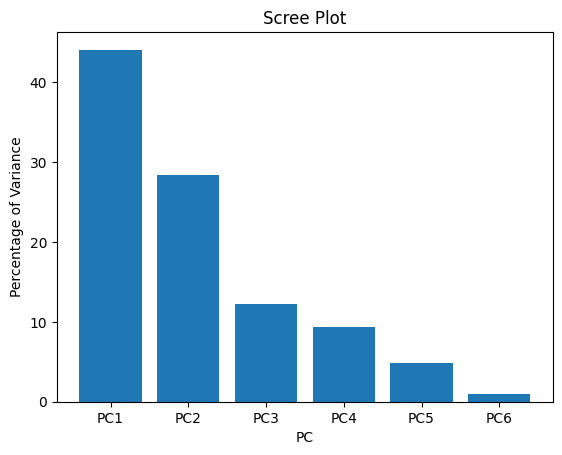

In [23]:
#scree plot to find number of PCs to be considered

#calculate percentage of variations of all pcs.
per_var= np.round(pca.explained_variance_ratio_*100,decimals=1)

labels=['PC'+str(x) for x in range(1,len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
plt.ylabel('Percentage of Variance')
plt.xlabel('PC')
plt.title('Scree Plot')

In [24]:
#Loading scores
loading_scores=pd.Series(pca.components_[0], index=colnames)
sorted_loading_scores= loading_scores.abs().sort_values(ascending=False) #loading scores of PC1
sorted_loading_scores= loading_scores.abs().sort_values(ascending=False) #sort by magnitude

top_10_genes=sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_genes])
#all numerical features have contribution to the PC1

Grocery             0.579256
Detergents_Paper    0.548640
Milk                0.545118
Delicassen          0.248682
Frozen              0.051189
Fresh               0.042884
dtype: float64


In [25]:
print(per_var)

[44.1 28.4 12.3  9.4  4.8  1. ]


First two PCS explain 72.5 percent of variance and first 4 PCs explain 94.2 variance in the data

---



In [26]:
#CLUSTERING HORECA CUSTOMERS
horeca= data[data['Channel'] ==1]
horeca.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
3,1,3,13265,1196,4221,6404,507,1788
8,1,3,5963,3648,6192,425,1716,750
15,1,3,10253,1114,3821,397,964,412
17,1,3,5876,6157,2933,839,370,4478
19,1,3,7780,2495,9464,669,2518,501


Scaling the horeca data

In [27]:
scld_horeca_data=preprocessing.scale(horeca[['Channel','Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']])
scld_horeca_data

array([[ 0.        , -0.01524865, -0.51917123, ...,  0.47134245,
        -0.2572584 ,  0.11840448],
       [ 0.        , -0.54405489,  0.04517414, ..., -0.589811  ,
         0.83959929, -0.21194347],
       [ 0.        , -0.23337579, -0.53804412, ..., -0.59478044,
         0.15735199, -0.31951341],
       ...,
       [ 0.        ,  1.86497544, -0.4650843 , ...,  0.13519516,
        -0.63285732,  0.29599036],
       [ 0.        , -0.23069628, -0.33849786, ..., -0.48101571,
        -0.56481404,  0.22565617],
       [ 0.        , -0.7740588 , -0.40363233, ..., -0.65370383,
        -0.28447572, -0.43408495]])

In [28]:
#Finding K value

Elbow plot

Text(0, 0.5, 'WCSS')

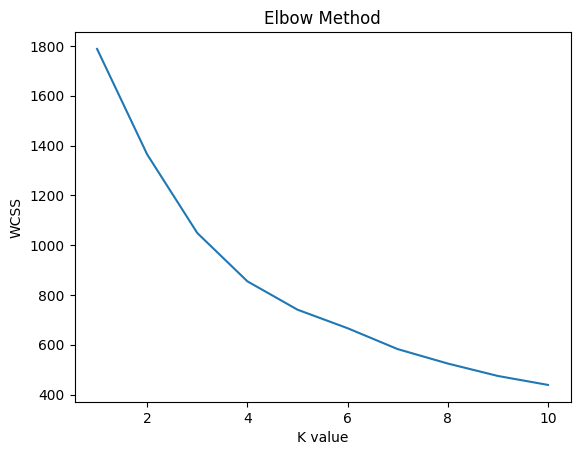

In [29]:
wcss=[]
for i in range(1,11):
  kmeans=KMeans(n_clusters=i,
  init='k-means++',max_iter=300,n_init=25)
  kmeans.fit(scld_horeca_data)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('K value')
plt.ylabel('WCSS')

Based on the elbow plot, there is no clear value for K

Silouhette Method

In [30]:
k_range = range(2, 11)

silhouette_scores = []
for k in k_range:

  kmeans = KMeans(n_clusters=k)
  kmeans.fit(scld_horeca_data)


  score = silhouette_score(scld_horeca_data, kmeans.labels_)
  silhouette_scores.append(score)

best_k_idx = silhouette_scores.index(max(silhouette_scores))
best_k = k_range[best_k_idx]

print("Optimal number of clusters (K) based on Silhouette method:", best_k)

Optimal number of clusters (K) based on Silhouette method: 2


Davies-Bouldin (DB) index

In [31]:

k_range = range(2, 6)

db_scores = []
for k in k_range:

  kmeans = KMeans(n_clusters=k)
  kmeans.fit(scld_horeca_data)


  score = davies_bouldin_score(scld_horeca_data, kmeans.labels_)
  db_scores.append(score)


best_k_idx = db_scores.index(min(db_scores))
best_k = k_range[best_k_idx]

print("Optimal number of clusters (K) based on Davies-Bouldin index:", best_k)


Optimal number of clusters (K) based on Davies-Bouldin index: 2


Our horeca data also contains 3 categories: Hotels, restaurants, Cafe. We can choose K=3.

Text(0, 0.5, 'PC2 28.4%')

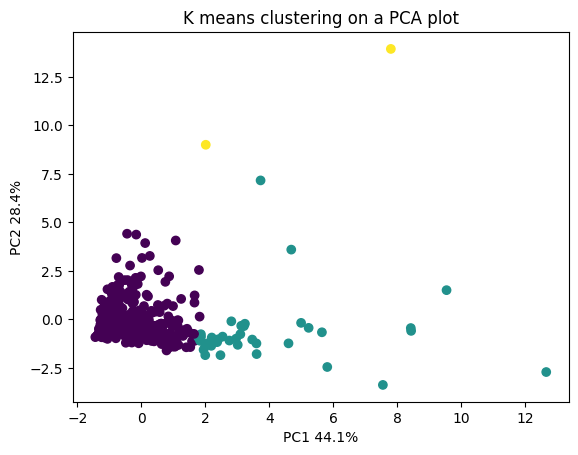

In [32]:
pca_df= pd.DataFrame(pca_data,columns=labels, index=[i for i in range(1,441)])
# a dataframe with pcs in columns and sample labels in rows
kmeans = KMeans(n_clusters=3)
kmeans.fit(pca_data)

# Get cluster labels
cluster_labels = kmeans.labels_
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels)

plt.title('K means clustering on a PCA plot')
plt.xlabel(f'PC1 {per_var[0]}%')
plt.ylabel(f'PC2 {per_var[1]}%')

Similar clustering can be performed on retail customers as well